### Something is wrong!
### Something is wrong?
### Something is wrong!

In [ ]:
SPOILERS / EXECUTIVE SUMMARY OF FINDINGS

* A large number of men born in the early 30s got lung disease and died in the last 90s - early 2000s. Especially if they lived in Worcester and a couple other towns.
I smell coal mines?

* Obesity problems

* Drug overdoses like WHOA. More than half of people have one on their record.



### Ok. Before I can figure out what is wrong I need to get an idea for what IS.
Let's take a look at the data files. 
No, wait. Let's think about it for a minute, first.

Things that could be wrong:
    a) The data is wrong
        approach: Do sanity checks on the individual tables wrt data completeness and 'correctness'.
    b) The data shows me something is wrong with the people.
        approach: Do sanity checks on the patient-centric tables wrt my biased expectations of usage and illness rates
    c) The data shows me something is being done wrong For the people
        approach: Look at costs, rxes, procedures, encounter rates, and - if they're there - deaths
    d) All of the above
        approach: Whatever random stuff I do as digressions
    


In [124]:
## First things first:  some imports
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import sklearn
import glob

In [9]:
# A quick tour of ALL the tables
fnames = glob.glob("*.csv")
fnames

['medications.csv',
 'providers.csv',
 'imaging_studies.csv',
 'allergies.csv',
 'procedures.csv',
 'organizations.csv',
 'conditions.csv',
 'careplans.csv',
 'encounters.csv',
 'immunizations.csv',
 'patients.csv',
 'concepts.csv',
 'observations.csv']

In [29]:
# We all know this is the central table
pats = pd.read_csv("patients.csv")
n_patients = len(set(pats['Id'].values))
print(n_patients)

# Hm. Are there dupes?
print(len(pats)) 
# No! Good job, recordkeepers.



8360
8360


In [134]:
## What about dead folks?
deaths = pats['DEATHDATE'].count()
deaths

3360

In [ ]:
## SO we have a round 5000 folks. CONVENIENT.

In [243]:
## OK. Super naive data exploration time.
## How big are the tables
## how far back does data go
## how many (on super average) are there of *thing* per patient

patient_linked=[]
independent=[]
for fname in fnames:
    root= fname.split(".")[0]
    df = pd.read_csv(fname)
    print("There are ---> {} rows in the ---> {} table.".format(len(df), root.upper()))
    print("That's {} per patient".format(len(df)/n_patients))
    if len(df)<1000000:
        for date_word in ['START','STOP','DATE','BIRTHDATE','DEATHDATE']:
            if date_word in df.columns:
                df[date_word]=df[date_word].apply(pd.to_datetime)

                print("earliest {}: {}, latest date: {}".format(date_word, min(df[date_word]), max(df[date_word])))

    print("How about nulls? -->")
    for column in df:
        if df[column].isnull().any():
            print('{0} has {1} null values'.format(column, df[column].isnull().sum())) 
    if 'PATIENT' in df.columns:
        patient_linked.append(root)
    else:
        independent.append(root)
    print()
    
print("TABLES JOINABLE TO PATIENT TABLE: {}".format(patient_linked))
print("DIM TABLES: {}".format(independent))

There are ---> 124759 rows in the ---> MEDICATIONS table.
That's 14.923325358851674 per patient
earliest START: 1909-11-26 00:00:00, latest date: 2019-05-06 00:00:00
earliest STOP: 1909-12-10 00:00:00, latest date: 2019-05-06 00:00:00
How about nulls? -->
STOP has 16524 null values
REASONCODE has 44940 null values
REASONDESCRIPTION has 44940 null values

There are ---> 125 rows in the ---> PROVIDERS table.
That's 0.014952153110047847 per patient
How about nulls? -->

There are ---> 8278 rows in the ---> IMAGING_STUDIES table.
That's 0.9901913875598086 per patient
earliest DATE: 1912-08-28 00:00:00, latest date: 2019-05-01 00:00:00
How about nulls? -->

There are ---> 3262 rows in the ---> ALLERGIES table.
That's 0.3901913875598086 per patient
earliest START: 1909-08-21 00:00:00, latest date: 2019-04-14 00:00:00
earliest STOP: NaT, latest date: NaT
How about nulls? -->
STOP has 2705 null values

There are ---> 419399 rows in the ---> PROCEDURES table.
That's 50.16734449760766 per patien

So I am super impressed with record keeping in Massandopolis, as it appears we have medical record information going back as far as 1908. 

I personally don't trust any information over 30, so we might have to ignore some of the old stuff later on.



... I think it's time to get to know the people of Massandopolis.

In [46]:
pats.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,ZIP
0,c0d528b6-cdae-4d98-8936-a270f8827eb7,2013-02-10,NaN,999-83-3170,NaN,NaN,NaN,Claudette391,Hahn503,NaN,NaN,NaN,white,french_canadian,F,Framingham Massandopolis US,239 Schaden Glen,Randolph,Massandopolis,2368.0
1,d709f84f-7d2c-440b-a979-2bc27d41f63a,1994-01-10,2019-01-07,999-31-7937,S99989196,X43239863X,Ms.,Christina143,Langworth352,NaN,NaN,NaN,black,dominican,F,Lynn Massandopolis US,535 Romaguera Annex Unit 82,Boston,Massandopolis,2108.0
2,92aa6efc-004f-4e01-b0be-9aafa40d9857,1989-08-27,NaN,999-59-2188,S99973592,X80581589X,Mrs.,Robbyn526,Eichmann909,NaN,Kohler843,M,hispanic,central_american,F,Salem Massandopolis US,986 Franecki Road Apt 37,Bellingham,Massandopolis,2019.0
3,f9b11b47-e8e8-4c3c-b279-36eba5086cfd,1988-10-09,NaN,999-48-9512,S99947146,X80365010X,Mr.,Earnest658,Bauch723,NaN,NaN,M,white,american,M,Concord Massandopolis US,451 Paucek Divide,Plymouth,Massandopolis,2360.0
4,c9d19013-4435-4b71-823a-c5023ba56195,1997-12-21,NaN,999-44-8705,S99938855,X28806996X,Mr.,Sung603,Schroeder447,NaN,NaN,NaN,white,polish,M,Reading Massandopolis US,123 Klocko Gateway,Natick,Massandopolis,1760.0


In [141]:
pats['BIRTHDATE']=pats['BIRTHDATE'].apply(pd.to_datetime)
pats['BIRTHYEAR']=pats['BIRTHDATE'].dt.year
pats['BIRTHDAY']=pats['BIRTHDATE'].dt.day
pats['BIRTHMONTH']=pats['BIRTHDATE'].dt.month


In [162]:
alive = pats[pats['DEATHDATE'].isnull()]
alive.name = 'alive'
dead = pats[pats['DEATHDATE'].notnull()]
dead.name = 'dead'
dead['DEATHYEAR']=dead['DEATHDATE'].apply(pd.to_datetime).dt.year


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


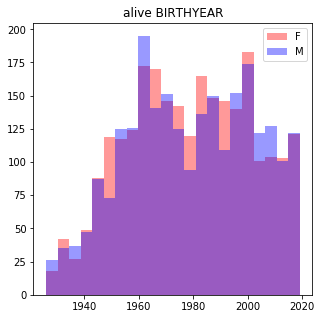

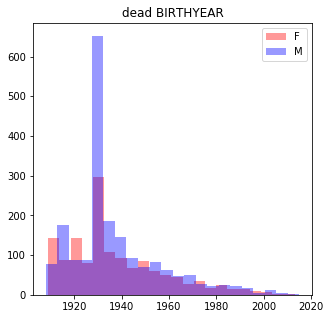

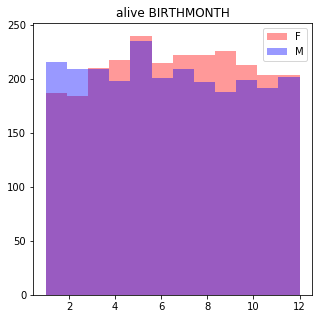

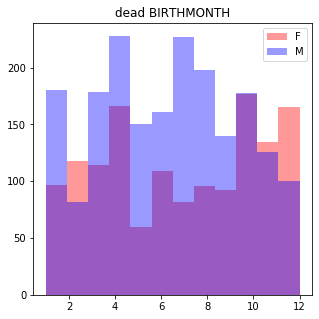

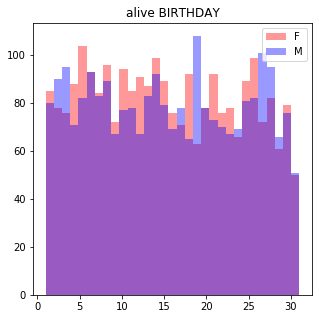

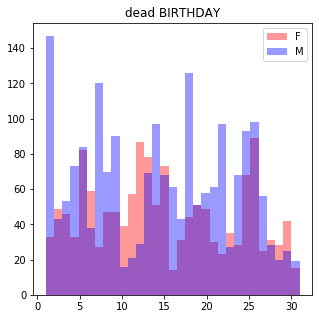

In [148]:
for sub_tup in [('BIRTHYEAR',22),('BIRTHMONTH',12),('BIRTHDAY',31)]:
    for status in [alive, dead]:
        bins = 12
        f=plt.figure(figsize=(5,5))
        plt.hist(status[status['GENDER']=='F'][sub_tup[0]], bins = sub_tup[1], color = 'r', alpha = 0.4, label='F')
        plt.hist(status[status['GENDER']=='M'][sub_tup[0]], bins = sub_tup[1], color = 'b', alpha = 0.4, label='M')
        plt.legend()
        plt.title(status.name + " "+ sub_tup[0])

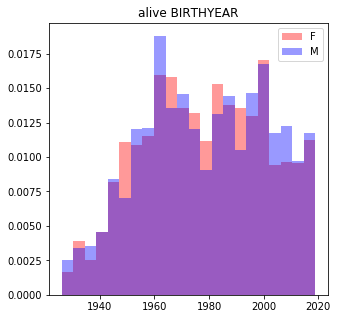

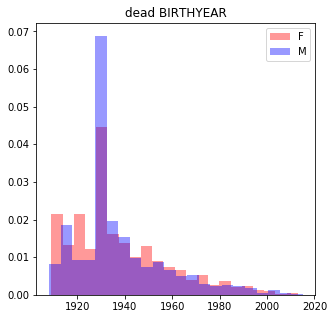

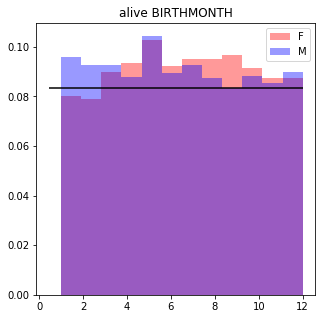

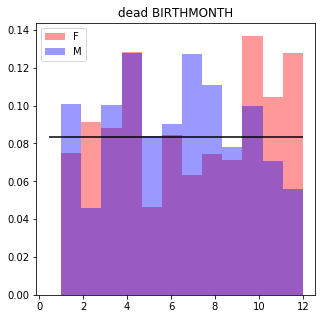

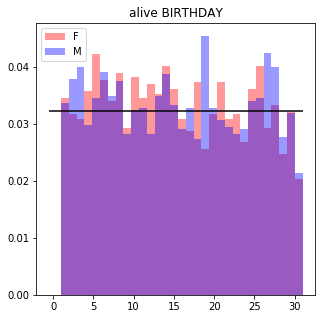

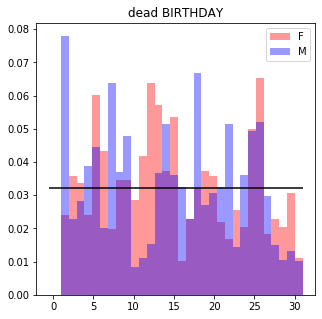

In [150]:
## OK so that's weird. Does it go away if I look at density instead of abs numbers?
for sub_tup in [('BIRTHYEAR',22),('BIRTHMONTH',12),('BIRTHDAY',31)]:
    for status in [alive, dead]:
        f=plt.figure(figsize=(5,5))
        plt.hist(status[status['GENDER']=='F'][sub_tup[0]], bins = sub_tup[1], color = 'r', alpha = 0.4, label='F', density=True)
        plt.hist(status[status['GENDER']=='M'][sub_tup[0]], bins = sub_tup[1], color = 'b', alpha = 0.4, label='M', density= True)
        xmin=plt.gca().get_xlim()[0]
        if sub_tup[0]!='BIRTHYEAR':
            plt.hlines(y=1/(sub_tup[1]), xmin=xmin, xmax = max(pats[sub_tup[0]].values))

        plt.legend()
        plt.title(status.name + " " + sub_tup[0])

In [220]:
dead['BIRTHYEAR'].value_counts()[:10]

1929    304
1931    240
1930    200
1932    168
1913     99
1933     88
1935     79
1914     77
1941     74
1916     66
Name: BIRTHYEAR, dtype: int64

In [219]:
dead[dead['BIRTHYEAR']<1933][dead['GENDER']=='M']['DEATHYEAR'].apply(lambda x: x-1930).value_counts()[:10]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


68    38
66    33
69    32
77    32
72    31
76    31
64    30
67    30
75    28
81    27
Name: DEATHYEAR, dtype: int64

In [182]:
alive['RACE'].value_counts()/len(alive)

white       0.7562
hispanic    0.1076
black       0.0716
asian       0.0604
native      0.0034
other       0.0008
Name: RACE, dtype: float64

In [183]:
dead['RACE'].value_counts()/len(dead)

white       0.717857
hispanic    0.150893
black       0.067560
asian       0.061905
native      0.001488
other       0.000298
Name: RACE, dtype: float64

In [234]:
dead[dead['BIRTHYEAR']<1933]['RACE'].value_counts()/len(dead[dead['BIRTHYEAR']<1933])

white       0.708129
hispanic    0.164757
black       0.070376
asian       0.056738
Name: RACE, dtype: float64

In [ ]:
# HISPANIC FOLK DIE MORE? THE DIFF BTW 10% of alive folk vs 15% of dead folk SEEMS ODD TO ME AT A GLANCE.
# IF I HAD MORE TIME I'D CHECK ON THEM MORE CLOSELY.

In [184]:
alive['GENDER'].value_counts()

F    2545
M    2455
Name: GENDER, dtype: int64

In [187]:
alive['MARITAL'].value_counts()

M    2679
S     653
Name: MARITAL, dtype: int64

In [230]:
alive['ETHNICITY'].value_counts()

irish               988
italian             617
english             456
french              336
puerto_rican        303
german              302
polish              219
portuguese          197
american            195
chinese             187
french_canadian     154
dominican           123
african             122
asian_indian        115
west_indian         113
scottish            110
russian              96
south_american       80
central_american     78
mexican              77
swedish              60
greek                51
american_indian      17
arab                  4
Name: ETHNICITY, dtype: int64

In [199]:
prop_deaths_early=dead[dead['BIRTHYEAR']<1940]['CITY'].value_counts()[:5]/len(dead[dead['BIRTHYEAR']<1940])

In [213]:
prop_deaths_late=dead[dead['BIRTHYEAR']>1940]['CITY'].value_counts()/len(dead[dead['BIRTHYEAR']>1940])

early_to_late = prop_deaths_early / prop_deaths_late
early_to_late[early_to_late > 1]

Brockton     3.847952
Everett      4.039092
Lynn         2.074876
Worcester    1.607732
Name: CITY, dtype: float64

In [221]:
dead[dead['BIRTHYEAR']<1940]['MARITAL'].value_counts()

M    1666
S     420
Name: MARITAL, dtype: int64

### INITIAL THOUGHTS ON PATIENTS

So, there appear to be a lot (A LOT) of men born in the late 30s using health services, and dying, here. A lot of people born in the late 30s, but way more men. THAT'S WEIRD.
I mean. They would have been too young for WW2 and Korea, too old for Vietnam, so here they are - demographic lottery winners?

All the same. There are WAY MORE men than there are women from the 30s using healthcare and dying. Men in their late 60s-70s HATE going to the doctor. Although, it looks like they were mostly married, and those guys wives make them go to the doctor (sexist but true last time I checked - married men die slower than singletons)

Something was obviously happenening to late-Depression-born men, maybe focussed around Brockton, Everett, Lynn and Worcester (or those are retirement towns - the men are dying in their late sixties) starting in the late 90s. Or hitting them in the late 90s.
...

MINOR POINTS
Also why would there be more women than men born in the fall, and in the second week of the month in general?
The month and day stuff looks like if I checked closer it'd be maybe within range of normal variation, so I'm going to drop it for now. But those birth years though. What??

I could probably rabbit-hole into patient data for ages, but I'm only supposed to spend an afternoon on this and I've clearly gotten distracted from basic data quality checks. On to the other files!

Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'BIRTHYEAR',
       'BIRTHDAY', 'BIRTHMONTH'],
      dtype='object')

### MEDICATIONS

In [222]:
meds = pd.read_csv("medications.csv")

In [236]:
meds.isnull().sum()

START                    0
STOP                 16524
PATIENT                  0
ENCOUNTER                0
CODE                     0
DESCRIPTION              0
COST                     0
DISPENSES                0
TOTALCOST                0
REASONCODE           44940
REASONDESCRIPTION    44940
dtype: int64

In [228]:
meds_plus_dem = meds.merge(pats, left_on="PATIENT", right_on="Id")

In [260]:
for code in meds['CODE'].value_counts().index[:20]:
    print(meds[meds['CODE']==code]['DESCRIPTION'].value_counts())
    print()

1 ML Epoetin Alfa 4000 UNT/ML Injection [Epogen]    22027
Name: DESCRIPTION, dtype: int64

Simvistatin 10 MG    20215
Name: DESCRIPTION, dtype: int64

Acetaminophen 325 MG Oral Tablet    8986
Name: DESCRIPTION, dtype: int64

Cisplatin 50 MG Injection    6654
Name: DESCRIPTION, dtype: int64

PACLitaxel 100 MG Injection    5432
Name: DESCRIPTION, dtype: int64

Amoxicillin 250 MG / Clavulanate 125 MG Oral Tablet    3732
Name: DESCRIPTION, dtype: int64

Acetaminophen 325 MG / Oxycodone Hydrochloride 5 MG Oral Tablet    2723
Acetaminophen 325 MG / oxyCODONE Hydrochloride 5 MG Oral Tablet     508
Name: DESCRIPTION, dtype: int64

Naproxen sodium 220 MG Oral Tablet    2781
Name: DESCRIPTION, dtype: int64

Abuse-Deterrent 12 HR Oxycodone Hydrochloride 15 MG Extended Release Oral Tablet    2756
Name: DESCRIPTION, dtype: int64

Acetaminophen 300 MG / HYDROcodone Bitartrate 5 MG [Vicodin]    2736
Name: DESCRIPTION, dtype: int64

Ibuprofen 200 MG Oral Tablet    2301
Name: DESCRIPTION, dtype: int64


In [264]:
#THAT'S A LOT OF CKD MEDS?! Or is it?
meds_plus_dem[meds_plus_dem['CODE']==205923]['BIRTHYEAR'].value_counts()[:10]

1931    4393
1916    2809
1930    2431
1914    2431
1940    2431
1909    2065
1934    1850
1918    1045
1949     763
1919     618
Name: BIRTHYEAR, dtype: int64

In [281]:
meds_plus_dem[meds_plus_dem['CODE']==205923][meds_plus_dem['GENDER']=='M']['BIRTHYEAR'].value_counts()[:10]

#WAIT. THE 1916, 1914, 1918, 1919, 1930, FOLK ARE ALL MEN - but women from 1931 suddenly are allowed to have ckd?
#UNIQUE PATIENTS FOR THOSE YEARS?

meds_plus_dem[meds_plus_dem['CODE']==205923][meds_plus_dem['GENDER']=='M']['Id'].value_counts()

meds_plus_dem[meds_plus_dem['CODE']==205923][meds_plus_dem['GENDER']=='F']['Id'].value_counts()
meds_plus_dem[meds_plus_dem['CODE']==205923]['Id'].nunique()
#AHA. Tonnes of that med, but only 17 patients. That makes sense, it's for a chronic condition.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


17

In [282]:
#Because opioids

In [292]:
meds_plus_dem['DESCRIPTION']=meds_plus_dem['DESCRIPTION'].str.lower()

meds_plus_dem[meds_plus_dem['DESCRIPTION'].str.contains("codone")]['Id'].nunique()

4146

In [293]:
#HALF THE PEOPLE HAVE HAD OPIOIDS?

In [294]:
#WHAT ABOUT JUST ALIVE PEOPLE?
meds_plus_dem[meds_plus_dem['DESCRIPTION'].str.contains("codone")][meds_plus_dem['DEATHDATE'].isnull()]['Id'].nunique()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


2269

In [295]:
2269/5000

0.4538

In [305]:
meds_plus_dem[meds_plus_dem['DESCRIPTION'].str.contains("codone")][meds_plus_dem['DEATHDATE'].isnull()]['BIRTHYEAR'].value_counts()[:10]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1986    182
1987    165
1989    151
1983    138
1984    135
1988    128
1994    123
1985    120
1996    116
1991    111
Name: BIRTHYEAR, dtype: int64

In [307]:
meds_plus_dem[meds_plus_dem['DESCRIPTION'].str.contains("codone")][meds_plus_dem['DEATHDATE'].isnull()][meds_plus_dem['BIRTHYEAR']>1980]['Id'].value_counts()[:10]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0b24afa8-2453-4d75-9b0f-34a150d510b5    15
bc96bbc2-d741-4ac5-a3f4-8dadb0dddc33    13
db153b45-5f34-4b37-b8a1-8d1779be8a21    13
448bbf28-b47d-4325-b45d-0dc6bc8f4f31    12
98e2e93a-8ef4-4b97-a4d8-fba2bf62ea75    11
fc74bf14-fc1c-4f4c-a2d2-190bafb84b00    10
4c12edfc-7da7-4103-8b4a-e7a958f92120    10
930582b8-d01b-4fc7-a731-ecd011eff16b    10
2b433be1-ae2c-4be7-9502-cc878db84e4d     9
98b4bce5-803d-4297-ae55-69c5dfe7fe42     9
Name: Id, dtype: int64

In [353]:
meds_plus_dem[meds_plus_dem['DESCRIPTION'].str.contains("codone")][meds_plus_dem['DEATHDATE'].isnull()]['REASONDESCRIPTION'].value_counts()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Posttraumatic stress disorder    7
Primary fibromyalgia syndrome    4
Name: REASONDESCRIPTION, dtype: int64

In [311]:
meds_plus_dem[meds_plus_dem['DESCRIPTION'].str.contains("codone")][meds_plus_dem['DEATHDATE'].isnull()][meds_plus_dem['BIRTHYEAR']>1980]['Id'].value_counts()[:10]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0b24afa8-2453-4d75-9b0f-34a150d510b5    15
bc96bbc2-d741-4ac5-a3f4-8dadb0dddc33    13
db153b45-5f34-4b37-b8a1-8d1779be8a21    13
448bbf28-b47d-4325-b45d-0dc6bc8f4f31    12
98e2e93a-8ef4-4b97-a4d8-fba2bf62ea75    11
fc74bf14-fc1c-4f4c-a2d2-190bafb84b00    10
4c12edfc-7da7-4103-8b4a-e7a958f92120    10
930582b8-d01b-4fc7-a731-ecd011eff16b    10
2b433be1-ae2c-4be7-9502-cc878db84e4d     9
98b4bce5-803d-4297-ae55-69c5dfe7fe42     9
Name: Id, dtype: int64

(array([1.12658e+05, 4.04000e+03, 1.55500e+03, 4.60000e+02, 1.34000e+02,
        1.40000e+01, 0.00000e+00, 0.00000e+00, 1.74000e+02, 5.72400e+03]),
 array([2.900000e-01, 7.014430e+02, 1.402596e+03, 2.103749e+03,
        2.804902e+03, 3.506055e+03, 4.207208e+03, 4.908361e+03,
        5.609514e+03, 6.310667e+03, 7.011820e+03]),
 <a list of 10 Patch objects>)

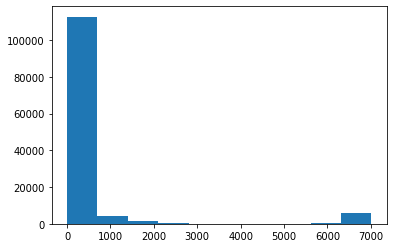

In [312]:
plt.hist(meds['COST'])

(array([1.24479e+05, 1.24000e+02, 6.50000e+01, 3.80000e+01, 1.90000e+01,
        5.00000e+00, 1.40000e+01, 6.00000e+00, 6.00000e+00, 3.00000e+00]),
 array([2.90000000e-01, 6.19834137e+05, 1.23966798e+06, 1.85950183e+06,
        2.47933568e+06, 3.09916952e+06, 3.71900337e+06, 4.33883722e+06,
        4.95867107e+06, 5.57850491e+06, 6.19833876e+06]),
 <a list of 10 Patch objects>)

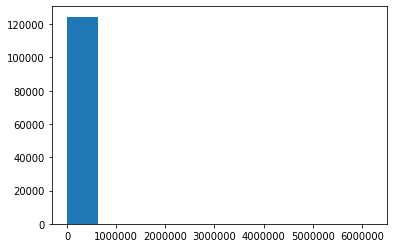

In [314]:
plt.hist(meds_plus_dem['TOTALCOST'])

In [334]:
meds['REASONDESCRIPTION'].value_counts()[:15]

Anemia (disorder)                                                        22027
Hyperlipidemia                                                           20215
Non-small cell carcinoma of lung  TNM stage 1 (disorder)                 10864
Acute bronchitis (disorder)                                               7721
Viral sinusitis (disorder)                                                3342
Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)     2444
Hypertension                                                              2421
Streptococcal sore throat (disorder)                                      2034
Chronic congestive heart failure (disorder)                               1403
Diabetes                                                                  1365
Escherichia coli urinary tract infection                                   925
Cystitis                                                                   648
Childhood asthma                                    

In [ ]:
#Cancer. Lung cancer is 20-30 / 100k people. So I'd expect 1-3 in my 8000 person sample per year. That's 

In [346]:
has_desc = meds_plus_dem[meds_plus_dem['REASONDESCRIPTION'].notnull()==True]
has_desc[has_desc['REASONDESCRIPTION'].str.contains("lung")]['Id'].nunique()

157

In [351]:
has_desc[has_desc['REASONDESCRIPTION'].str.contains("lung")][has_desc['BIRTHYEAR']<1935]['Id'].nunique()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


105

In [352]:
#OK. SO IF I HAD MORE TIME I'D WANT TO KNOW WHERE THE MASSANDOPOLIS COAL MINES AND COAL POWER PLANTS ARE. I"M NOT SAYIN I"M JUST SAYIN.



### OBSERVATIONS

In [354]:
obs = pd.read_csv("observations.csv")

In [416]:
obs.columns

Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'VALUE', 'UNITS',
       'TYPE'],
      dtype='object')

In [417]:
obs['DESCRIPTION'].value_counts()

Pain severity - 0-10 verbal numeric rating [Score] - Reported               217754
Systolic Blood Pressure                                                     165138
Diastolic Blood Pressure                                                    165138
Tobacco smoking status NHIS                                                 163795
Body Height                                                                 163795
Body Weight                                                                 163795
Body Mass Index                                                             150086
Sodium                                                                       97070
Creatinine                                                                   97070
Urea Nitrogen                                                                97070
Glucose                                                                      97070
Chloride                                                                     97070
Carb

In [493]:
causes_of_death = obs[obs['DESCRIPTION'].apply(lambda x: 'Death' in x) == True]

In [494]:
len(causes_of_death)

2929

In [495]:
len(dead)

3360

In [497]:
causes_of_death['VALUE'].value_counts()/len(causes_of_death)

Natural death with unknown cause                            0.485149
Drug overdose                                               0.101400
Sudden Cardiac Death                                        0.093547
Myocardial Infarction                                       0.073062
Non-small cell lung cancer (disorder)                       0.036190
Stroke                                                      0.034483
Pneumonia                                                   0.025265
Neoplasm of prostate                                        0.024923
Pulmonary emphysema (disorder)                              0.019461
Cardiac Arrest                                              0.019461
Alzheimer's disease (disorder)                              0.017753
Malignant tumor of colon                                    0.010925
Chronic obstructive bronchitis (disorder)                   0.010584
Bullet wound                                                0.009901
Secondary malignant neoplasm of co

In [454]:
bmis = obs[obs['DESCRIPTION']=='Body Mass Index'].sort_values("DATE").groupby("PATIENT").last()

#KEEPS THE MOST RECENT BMI OBSERVATION FOR EACH PATIENT

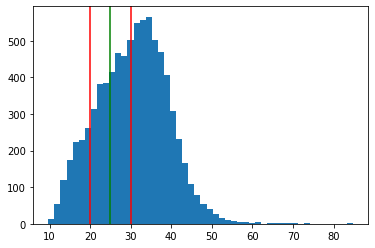

In [461]:
#print(bmis.head())

plt.hist(bmis['VALUE'].apply(float), bins=50)
plt.axvline(x=25, color='g')
plt.axvline(x=20, color = 'r')
plt.axvline(x=30, color = 'r')

### ALLERGIES

In [359]:
allergy = pd.read_csv("allergies.csv")

In [414]:
allergy.columns

Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')

In [415]:
allergy['DESCRIPTION'].value_counts()

Allergy to mould            470
Dander (animal) allergy     434
House dust mite allergy     344
Allergy to tree pollen      326
Allergy to grass pollen     318
Shellfish allergy           269
Allergy to peanuts          177
Allergy to bee venom        143
Allergy to fish             138
Allergy to eggs             131
Latex allergy               131
Allergy to nut              127
Allergy to wheat            127
Allergy to dairy product     79
Allergy to soya              48
Name: DESCRIPTION, dtype: int64

### ENCOUNTERS

In [355]:
enc = pd.read_csv("encounters.csv")

In [408]:
enc.columns

Index(['Id', 'START', 'STOP', 'PATIENT', 'PROVIDER', 'ENCOUNTERCLASS', 'CODE',
       'DESCRIPTION', 'COST', 'REASONCODE', 'REASONDESCRIPTION'],
      dtype='object')

In [411]:
enc['DESCRIPTION'].value_counts()[:20]

Encounter for problem (procedure)         226850
Encounter for check up (procedure)        173961
Outpatient procedure (procedure)           57203
Encounter for symptom                      46989
Prenatal visit                             32280
Encounter for problem                      24822
Emergency Room Admission                   24206
Follow-up encounter                        20262
Outpatient procedure                       19459
Drug rehabilitation and detoxification     17298
Patient encounter procedure                16808
Encounter for 'check-up'                   14492
Consultation for treatment                 13376
Encounter Inpatient                        12178
Emergency room admission (procedure)       11169
Emergency Encounter                         8176
Prenatal initial visit                      7649
Postnatal visit                             3749
Obstetric emergency hospital admission      3741
Death Certification                         2929
Name: DESCRIPTION, d

In [413]:
enc['REASONDESCRIPTION'].value_counts()

Normal pregnancy                                                         43647
Drug overdose                                                            22396
Hyperlipidemia                                                           20215
Viral sinusitis (disorder)                                               17064
Acute viral pharyngitis (disorder)                                        9394
Acute bronchitis (disorder)                                               8283
Child attention deficit disorder                                          7927
Chronic pain                                                              3944
Chronic intractable migraine without aura                                 3901
Impacted molars                                                           3888
Sinusitis (disorder)                                                      2797
Chronic congestive heart failure (disorder)                               2684
Acute bacterial sinusitis (disorder)                

### CONDITIONS

In [358]:
cond = pd.read_csv("conditions.csv")

In [406]:
cond.columns

Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')

In [476]:
cond = pd.merge(cond, pats, left_on="PATIENT", right_on="Id")

In [477]:
cond['DESCRIPTION'].value_counts()

Viral sinusitis (disorder)                                               16893
Acute viral pharyngitis (disorder)                                        9389
Acute bronchitis (disorder)                                               7686
Normal pregnancy                                                          6079
Drug overdose                                                             4710
Body mass index 30+ - obesity (finding)                                   4143
Anemia (disorder)                                                         2979
Chronic pain                                                              2891
Prediabetes                                                               2871
Chronic intractable migraine without aura                                 2857
Impacted molars                                                           2838
Hypertension                                                              2247
Otitis media                                        

In [478]:
cond[cond['DESCRIPTION'].str.contains("overdose")]['PATIENT'].nunique()

#THAT CAN'T BE RIGHT...

4710

In [479]:
cond['PATIENT'].nunique() < pats['Id'].nunique()
len(set(pats['Id'].values).intersection(set(cond['PATIENT'].values)))
#That's fine. Some patients don't have any conditions.

8226

In [484]:
len(cond[cond['DESCRIPTION'].str.contains("overdose")][cond['DEATHDATE'].isnull()==False])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1609

In [485]:
#THAT SEEMS LIKE A LOT OF OVERDOSES TO ME?

### PROVIDERS

In [467]:
prov = pd.read_csv("providers.csv")

In [404]:
prov.columns

Index(['Id', 'ORGANIZATION', 'NAME', 'GENDER', 'SPECIALITY', 'ADDRESS', 'CITY',
       'STATE', 'ZIP', 'UTILIZATION'],
      dtype='object')

In [405]:
prov.head()

,Id,ORGANIZATION,NAME,GENDER,SPECIALITY,ADDRESS,CITY,STATE,ZIP,UTILIZATION
0,af944a62-54d2-4af0-b441-255e7f399cd2,ef58ea08-d883-3957-8300-150554edc8fb,Noe500 Dibbert990,M,GENERAL PRACTICE,60 HOSPITAL ROAD,LEOMINSTER,MA,1453,33568
1,66105bcb-96ef-4289-b1fb-996c631e5ea2,69176529-fd1f-3b3f-abce-a0a3626769eb,Mariam937 Gleason633,F,GENERAL PRACTICE,330 MOUNT AUBURN STREET,CAMBRIDGE,MA,2138,57842
2,e164c630-bacb-47e3-81d3-6821b8f5d112,5e765f2b-e908-3888-9fc7-df2cb87beb58,Dagny669 Schoen8,F,GENERAL PRACTICE,211 PARK STREET,ATTLEBORO,MA,2703,72109
3,9cdc032d-fcad-4aef-a5ef-b42626e9c34e,f1fbcbfb-fcfa-3bd2-b7f4-df20f1b3c3a4,Tyron580 Torphy630,M,GENERAL PRACTICE,ONE GENERAL STREET,LAWRENCE,MA,1842,66339
4,3880a375-efa5-456b-bcdf-b5aee0280512,e002090d-4e92-300e-b41e-7d1f21dee4c6,Loren192 Fay398,M,GENERAL PRACTICE,1493 CAMBRIDGE STREET,CAMBRIDGE,MA,2138,57789


### PROCEDURES

In [360]:
proc = pd.read_csv("procedures.csv")

In [402]:
proc.columns

Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION', 'COST',
       'REASONCODE', 'REASONDESCRIPTION'],
      dtype='object')

In [418]:
proc['DESCRIPTION'].value_counts()

Documentation of current medications                               73957
Auscultation of the fetal heart                                    33693
Evaluation of uterine fundal height                                33693
Renal dialysis (procedure)                                         23892
Subcutaneous immunotherapy                                         19430
Intramuscular injection                                            13385
Electrical cardioversion                                           10214
Colonoscopy                                                         9444
Hemoglobin / Hematocrit / Platelet count                            7565
Combined chemotherapy and radiation therapy (procedure)             7536
Cognitive and behavioral therapy                                    7238
Depression screening                                                5938
Standard pregnancy test                                             5914
Ultrasound scan for fetal viability                

In [403]:
proc['REASONDESCRIPTION'].value_counts()

Normal pregnancy                                                         182604
Atrial Fibrillation                                                       12596
Child attention deficit disorder                                           7238
Acute bronchitis (disorder)                                                5760
Non-small cell carcinoma of lung  TNM stage 1 (disorder)                   5565
Pulmonary emphysema (disorder)                                             3273
Acute viral pharyngitis (disorder)                                         2983
Chronic obstructive bronchitis (disorder)                                  2821
Polyp of colon                                                             2292
Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)      1246
Streptococcal sore throat (disorder)                                       1165
Fracture of forearm                                                         829
Fracture of clavicle                    

### PLANS AND ORGS

In [363]:
plans = pd.read_csv("careplans.csv")
orgs = pd.read_csv("organizations.csv")

In [400]:
orgs.columns

Index(['Id', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE',
       'UTILIZATION'],
      dtype='object')

In [401]:
orgs.head()

,Id,NAME,ADDRESS,CITY,STATE,ZIP,PHONE,UTILIZATION
0,ef58ea08-d883-3957-8300-150554edc8fb,HEALTHALLIANCE HOSPITALS INC,60 HOSPITAL ROAD,LEOMINSTER,MA,1453,9784662000,33568
1,69176529-fd1f-3b3f-abce-a0a3626769eb,MOUNT AUBURN HOSPITAL,330 MOUNT AUBURN STREET,CAMBRIDGE,MA,2138,6174923500,57842
2,5e765f2b-e908-3888-9fc7-df2cb87beb58,STURDY MEMORIAL HOSPITAL,211 PARK STREET,ATTLEBORO,MA,2703,5082225200,72109
3,f1fbcbfb-fcfa-3bd2-b7f4-df20f1b3c3a4,LAWRENCE GENERAL HOSPITAL,ONE GENERAL STREET,LAWRENCE,MA,1842,9786834000,66339
4,e002090d-4e92-300e-b41e-7d1f21dee4c6,CAMBRIDGE HEALTH ALLIANCE,1493 CAMBRIDGE STREET,CAMBRIDGE,MA,2138,6176652300,57789


In [398]:
plans.columns

Index(['Id', 'START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION',
       'REASONCODE', 'REASONDESCRIPTION'],
      dtype='object')

In [399]:
plans['DESCRIPTION'].value_counts()

Respiratory therapy                                               8245
Care plan (record artifact)                                       4429
Routine antenatal care                                            4239
Diabetes self management plan                                     3178
Physical therapy procedure                                        2936
Fracture care                                                     2500
Wound care                                                        2410
Musculoskeletal care                                              1896
Head injury rehabilitation                                        1238
Hyperlipidemia clinical management plan                           1219
Self care                                                         1201
Urinary tract infection care                                       737
Overactivity/inattention behavior management                       689
Burn care                                                          617
Cancer

### IMMUNIZATIONS

In [394]:
imm = pd.read_csv("immunizations.csv")

In [395]:
imm.head()

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,COST
0,2013-02-10,c0d528b6-cdae-4d98-8936-a270f8827eb7,1ef67c37-7306-4be4-9668-a93f34972544,8,Hep B adolescent or pediatric,140.52
1,2013-03-17,c0d528b6-cdae-4d98-8936-a270f8827eb7,158ced22-0023-4934-b046-451696f2d516,8,Hep B adolescent or pediatric,140.52
2,2013-05-19,c0d528b6-cdae-4d98-8936-a270f8827eb7,3980f194-389d-42f5-b477-f7c99598d6be,49,Hib (PRP-OMP),140.52
3,2013-05-19,c0d528b6-cdae-4d98-8936-a270f8827eb7,3980f194-389d-42f5-b477-f7c99598d6be,119,rotavirus monovalent,140.52
4,2013-05-19,c0d528b6-cdae-4d98-8936-a270f8827eb7,3980f194-389d-42f5-b477-f7c99598d6be,10,IPV,140.52


In [396]:
imm['DESCRIPTION'].value_counts()

Influenza  seasonal  injectable  preservative free    121749
Td (adult) preservative free                           10304
DTaP                                                    6136
IPV                                                     5590
Hib (PRP-OMP)                                           3901
Hep B  adolescent or pediatric                          3841
meningococcal MCV4P                                     3492
Pneumococcal conjugate PCV 13                           3277
Hep A  adult                                            3231
HPV  quadrivalent                                       3072
MMR                                                     2732
varicella                                               2630
zoster                                                  2472
Hep A  ped/adol  2 dose                                 2458
Hep B  adult                                            2056
pneumococcal polysaccharide vaccine  23 valent          1911
rotavirus  monovalent   

### IMAGING STUDIES

In [385]:
imaging = pd.read_csv("imaging_studies.csv")


In [392]:
imaging.columns

Index(['Id', 'DATE', 'PATIENT', 'ENCOUNTER', 'BODYSITE_CODE',
       'BODYSITE_DESCRIPTION', 'MODALITY_CODE', 'MODALITY_DESCRIPTION',
       'SOP_CODE', 'SOP_DESCRIPTION'],
      dtype='object')

In [388]:
imaging['BODYSITE_DESCRIPTION']=imaging['BODYSITE_DESCRIPTION'].apply(lambda x: x.lower())
imaging['BODYSITE_DESCRIPTION'].value_counts()

thoracic structure (body structure)             3195
thoracic                                        1366
arm                                              666
clavicle                                         622
wrist                                            527
thoracic structure                               525
ankle                                            515
knee                                             338
chest                                            263
pelvis                                           214
structure of right upper quadrant of abdomen      47
Name: BODYSITE_DESCRIPTION, dtype: int64

In [389]:
thoracic = imaging[imaging['BODYSITE_DESCRIPTION'].str.contains('thoracic')]

In [393]:
thoracic

,Id,DATE,PATIENT,ENCOUNTER,BODYSITE_CODE,BODYSITE_DESCRIPTION,MODALITY_CODE,MODALITY_DESCRIPTION,SOP_CODE,SOP_DESCRIPTION
5,99909564-2f6d-4334-b97b-a047a9db726a,2004-10-26,a66bda4b-652d-4b76-b6fd-8aea3b26ad8a,1e60606d-d793-4c07-b8eb-df1e172c4322,261179002,thoracic,US,Ultrasound,1.2.840.10008.5.1.4.1.1.3.1,Ultrasound Multiframe Image Storage
6,d7c3b4a4-f529-4366-bb6e-cbe1d99aeffb,2006-04-19,a66bda4b-652d-4b76-b6fd-8aea3b26ad8a,8fd84b96-f4b2-4e1e-a7a9-1fec8781c698,261179002,thoracic,US,Ultrasound,1.2.840.10008.5.1.4.1.1.3.1,Ultrasound Multiframe Image Storage
7,432ad88d-acec-4adf-86ff-4f0da22d84d7,2006-10-16,a66bda4b-652d-4b76-b6fd-8aea3b26ad8a,ab9bb7f9-64b1-49f3-98ad-78b33bf7bd80,51185008,thoracic structure (body structure),CR,Computed Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage – for Presentation
8,5de9f73e-bec2-481f-b44a-80103be687c2,2006-10-16,a66bda4b-652d-4b76-b6fd-8aea3b26ad8a,04a8c66f-2831-47a5-a86c-2292d485dbfe,261179002,thoracic,US,Ultrasound,1.2.840.10008.5.1.4.1.1.3.1,Ultrasound Multiframe Image Storage
9,519ea88a-c304-415f-a96c-7eda22b75afd,2006-10-16,a66bda4b-652d-4b76-b6fd-8aea3b26ad8a,04a8c66f-2831-47a5-a86c-2292d485dbfe,51185008,thoracic structure,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage – for Presentation
15,b8728ae4-ebce-48ac-b364-16950bc69fe5,2015-09-12,19f152b5-004e-4002-9875-db61b9ce4118,4f13deaa-2b13-4b7f-ae6c-a9ee1dc43bb1,261179002,thoracic,US,Ultrasound,1.2.840.10008.5.1.4.1.1.3.1,Ultrasound Multiframe Image Storage
16,2beec696-3954-43a5-a6bc-b6887fc29d36,2016-03-10,19f152b5-004e-4002-9875-db61b9ce4118,572f9226-7827-4fbb-9fb8-99e315332613,51185008,thoracic structure (body structure),CR,Computed Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage – for Presentation
17,6cf8f158-e843-4022-87c4-93cbe9f4805b,2016-03-10,19f152b5-004e-4002-9875-db61b9ce4118,2df0329f-e657-42ab-9646-6f493ed54d0b,261179002,thoracic,US,Ultrasound,1.2.840.10008.5.1.4.1.1.3.1,Ultrasound Multiframe Image Storage
18,78ecad24-8218-4234-ba83-b8d840846c01,2016-03-10,19f152b5-004e-4002-9875-db61b9ce4118,2df0329f-e657-42ab-9646-6f493ed54d0b,51185008,thoracic structure,DX,Digital Radiography,1.2.840.10008.5.1.4.1.1.1.1,Digital X-Ray Image Storage – for Presentation
29,ef149e56-fffa-4f10-ba22-e37eabbb8bcf,2005-01-31,aee50cc5-d8d5-4fd9-90d7-ac43931c8e60,1cab502f-b8d7-42e1-9423-3b18df6189d9,51185008,thoracic structure (body structure),CT,Computed Tomography,1.2.840.10008.5.1.4.1.1.2,CT Image Storage


### MEDICAL CONCEPTS

In [375]:
#File is missing a header, so I added column names along the same lines as other files
concepts = pd.read_csv("concepts.csv", header=None, names = ['code_type','code','description','reason_description'])

In [376]:
concepts

,code_type,code,description,reason_description
0,LOINC,10230-1,Left ventricular Ejection fraction,Congestive Heart Failure
1,LOINC,14959-1,Microalbumin Creatinine Ratio,Wellness Encounters
2,LOINC,19926-5,FEV1/FVC,COPD
3,LOINC,24321-2,Basic Metabolic 2000 Panel,Metabolic Syndrome Standards of Care
4,LOINC,24323-8,Comprehensive metabolic 2000 panel - Serum or ...,Veteran Prostate Cancer|Congestive Heart Failu...
5,LOINC,24357-6,Urinalysis macro (dipstick) panel - Urine,Veteran Prostate Cancer|Lung Cancer|Dialysis|M...
6,LOINC,24360-0,Hemoglobin and Hematocrit panel - Blood,anemia_sub
7,LOINC,28245-9,Abuse Status [OMAHA],Homelessness
8,LOINC,2857-1,Prostate specific Ag [Mass/volume] in Serum or...,Veteran Prostate Cancer
9,LOINC,29463-7,Body Weight,Wellness Encounters
